## Motif analyses on CLIP/RIP binding sites and DRNs in diffBUM-HMM and deltaSHAPE data.
For this to work you need to have the pyCRAC package and MEME tool suite installed.

In [2]:
import os
import math
import sys
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import comb
from more_itertools import pairwise
from scipy.stats import hypergeom,chisquare,fisher_exact
from matplotlib import rcParams
from collections import defaultdict
from pyCRAC.Methods import sortbyvalue,contigousarray2Intervals

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['pdf.fonttype'] = 42


Bad key "text.kerning_factor" on line 4 in
/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [22]:
def normalizeIntervalLength(start,end,chromosomelength,length=20):
    """ Extends or trims the interval coordinates to a set length. Default = 20 bp. """
    newstart = int()
    newend = int()
    if start - length < 0: start = 1 # to make sure that the start is always a positive number 
    if end + length > chromosomelength: end = chromosomelength # to make sure that interval doesn't go beyond the chromosome boundaries.
    actlength  = end - start
    difference = length - actlength
    if difference == 0:
        return start,end
    else:
        newstart = round(float(start) - float(difference)/2.0)
        if newstart < 0: newstart = 1
        newend = round(float(end) + float(difference)/2.0)
        if newend > chromosomelength: newend = chromosomelength
        return int(newstart),int(newend) # convert back to integers

In [23]:
def intervalsFromClosePositions(positions,mindistance=5):
    """ Merges positions that are within a specific distance
    to their neighbours:
    [1,3,5,15,20,30,35,36,37,69,70,80,90,91]
    should become:
    [(1, 5), (15, 20), (30, 37), (69, 70), (80, 80), (90, 91)]

    """
    start = None
    end	  = None
    intervallist = list()
    for nr,i in enumerate(sorted(list(positions))):
        if not start:
            start = i
        try:
            if positions[nr+1] - positions[nr] <= mindistance:
                continue
            elif positions[nr+1] - positions[nr] > mindistance:
                end = i
                intervallist.append((start,end))
                start = positions[nr+1]
        except IndexError:
            if start:
                end = i
                intervallist.append((start,end))
            break
    return intervallist

### Loading the big dataframe:

In [24]:
data = pd.read_csv('../../New_data_table.txt',\
                    sep="\t",\
                    header=0,\
                    index_col=0)

### Masking positions not considered by deltaSHAPE:
Any positions that have -999 values should not be further considered as these were positions where there was insufficient coverage.

In [25]:
positionstomask = data[(data["SHAPE_reactivity_ex_vivo_1"] < -900) | 
                       (data["SHAPE_reactivity_ex_vivo_2"] < -900) |
                       (data["SHAPE_reactivity_in_cell_1"] < -900) | 
                       (data["SHAPE_reactivity_in_cell_2"] < -900)].index
print(len(positionstomask))
data.loc[positionstomask,data.columns[11:]] = np.nan

2517


In [26]:
data.columns

Index(['nucleotide', 'CELF1', 'FUS', 'HuR', 'PTBP1', 'RBFOX2', 'TARDBP',
       'SHAPE_reactivity_ex_vivo_1', 'SHAPE_reactivity_ex_vivo_2',
       'SHAPE_reactivity_in_cell_1', 'SHAPE_reactivity_in_cell_2',
       'deltaSHAPE_rep1', 'deltaSHAPE_rep2', 'dStruct', 'dStruct_scaled',
       'unmodified', 'ex_vivo', 'in_vivo', 'both', 'scaled_unmodified',
       'scaled_ex_vivo', 'scaled_in_vivo', 'scaled_both', 'base_paired_to'],
      dtype='object')

In [27]:
data.head()

,nucleotide,CELF1,FUS,HuR,PTBP1,RBFOX2,TARDBP,SHAPE_reactivity_ex_vivo_1,SHAPE_reactivity_ex_vivo_2,SHAPE_reactivity_in_cell_1,...,dStruct_scaled,unmodified,ex_vivo,in_vivo,both,scaled_unmodified,scaled_ex_vivo,scaled_in_vivo,scaled_both,base_paired_to
1,C,0,0,0,0,0,0,-999.0,-999.0,-999.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,G,0,0,0,0,0,0,-999.0,-999.0,-999.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,G,0,0,0,0,0,0,-999.0,-999.0,-999.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C,0,0,0,0,0,0,-999.0,-999.0,-999.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,T,0,0,0,0,0,0,-999.0,-999.0,-999.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Now doing Motif analyses:

### First I need to make fasta files for all the protein binding sites in Xist and find their motifs:
I will normalize the interval size to a fixed lenght so that MEME can deal better with it. I will group together those DRNs that are within 2nt distance from each other.

In [28]:
data.columns

Index(['nucleotide', 'CELF1', 'FUS', 'HuR', 'PTBP1', 'RBFOX2', 'TARDBP',
       'SHAPE_reactivity_ex_vivo_1', 'SHAPE_reactivity_ex_vivo_2',
       'SHAPE_reactivity_in_cell_1', 'SHAPE_reactivity_in_cell_2',
       'deltaSHAPE_rep1', 'deltaSHAPE_rep2', 'dStruct', 'dStruct_scaled',
       'unmodified', 'ex_vivo', 'in_vivo', 'both', 'scaled_unmodified',
       'scaled_ex_vivo', 'scaled_in_vivo', 'scaled_both', 'base_paired_to'],
      dtype='object')

In [29]:
data.head()

,nucleotide,CELF1,FUS,HuR,PTBP1,RBFOX2,TARDBP,SHAPE_reactivity_ex_vivo_1,SHAPE_reactivity_ex_vivo_2,SHAPE_reactivity_in_cell_1,...,dStruct_scaled,unmodified,ex_vivo,in_vivo,both,scaled_unmodified,scaled_ex_vivo,scaled_in_vivo,scaled_both,base_paired_to
1,C,0,0,0,0,0,0,-999.0,-999.0,-999.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,G,0,0,0,0,0,0,-999.0,-999.0,-999.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,G,0,0,0,0,0,0,-999.0,-999.0,-999.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C,0,0,0,0,0,0,-999.0,-999.0,-999.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,T,0,0,0,0,0,0,-999.0,-999.0,-999.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
chromosomelength = len(data.index)

### Setting the length of each interval for motif analyses:

In [13]:
fixedlength = 30

### Setting the threshold for selecting DRNs in the diffBUM-HMM data:

In [31]:
threshold = 0.95

In [32]:
proteins = ["CELF1","FUS","HuR","PTBP1","RBFOX2","TARDBP"]

In [33]:
proteinfastas = list()
for protein in proteins:
    outfilename = "%s_Xist_RNA_binding_sites.fa" % protein
    #print(outfilename)
    outfile = open(outfilename,"w")
    proteinfastas.append(outfilename)
    indices = data[data[protein] > 0].index
    intervals = intervalsFromClosePositions(indices)
    print("%s:\t%s" % (protein,len(intervals)))
    count = 1
    for (i,j) in intervals:
        start,end = normalizeIntervalLength(i,j,chromosomelength,fixedlength)
        sequence = data.loc[start:end+1,"nucleotide"].values
        sequence = "".join(sequence)
        outfile.write(">%s_%s\n%s\n" % (protein,count,sequence))
        count += 1
    outfile.close()

CELF1:	21
FUS:	107
HuR:	12
PTBP1:	22
RBFOX2:	3
TARDBP:	17


In [34]:
proteinfastas = " ".join(proteinfastas)

In [35]:
print(proteinfastas)

CELF1_Xist_RNA_binding_sites.fa FUS_Xist_RNA_binding_sites.fa HuR_Xist_RNA_binding_sites.fa PTBP1_Xist_RNA_binding_sites.fa RBFOX2_Xist_RNA_binding_sites.fa TARDBP_Xist_RNA_binding_sites.fa


### Running meme on these sequences:

In [18]:
%%bash -s "$proteinfastas"

DIR=$HOME/meme/bin

for i in $1
do
    echo $i
    FILE="$(basename -- $i)"
    FILE=${FILE%.fa}
    PREFIX=MEME_
    OUTFILE=$PREFIX$FILE
    $DIR/meme-chip \
        -meme-minw 4 \
        -meme-maxw 10 \
        -meme-nmotifs 3 \
        -meme-p 8 \
        -meme-mod anr \
        -norc \
        -rna \
        -noecho \
        -oc $OUTFILE $i &
done

CELF1_Xist_RNA_binding_sites.fa
FUS_Xist_RNA_binding_sites.fa
HuR_Xist_RNA_binding_sites.fa
PTBP1_Xist_RNA_binding_sites.fa
RBFOX2_Xist_RNA_binding_sites.fa
TARDBP_Xist_RNA_binding_sites.fa


### Now doing it for the diffBUM_HMM and deltaSHAPE sites. Fragment sizes = fixedlength:
All the DRNs that were located within a 5 nucleotide window from each other were grouped into a single interval and length of this interval was normalized (so either extended or trimmed) to the fixed length (30 bp for these analyses). The reason for doing this is because otherwise the analyes would generate for each DRN a sequence containing the DRN in the middle and many of these sequences could overlap if the DRNs are in quite close proximity. This would result in a much higher enrichment of motifs from regions that have a high concentration of DRNs. So this is why they were first grouped together. 

In [36]:
 intervallengthcounter = defaultdict(lambda: defaultdict(int))

### diffBUM_HMM:

In [40]:
sequence = "".join(data.nucleotide.values)

outfile = open("diffBUM_HMM_ex_vivo_%s_mers.fa" % fixedlength,"w")

### How many DRNs are there in the data?:
ex_vivo_pos = data[data.ex_vivo >= threshold].index

### intervalsFromClosePositions groups the DRNs together in intervals.
intervals = intervalsFromClosePositions(ex_vivo_pos,)

### This prints the number of intervals that were detected and how many DRNs there were in the data.
print(len(intervals))
print(len(ex_vivo_pos))

count = 0

for (i,j) in intervals:
    length = (j-i)+1
    intervallengthcounter["diffBUM_HMM_ex_vivo"][length] += 1
    ### These intervals are then set to a fixed length here:
    start,end = normalizeIntervalLength(i,j,chromosomelength,fixedlength)
    sequence = data.loc[start:end+1,"nucleotide"].values
    sequence = "".join(sequence)
    outfile.write(">diffBUM_HMM_ex_vivo_%s\n%s\n" % (count,sequence))
    count += 1
outfile.close()
        
in_vivo_pos = data[data.in_vivo >= threshold].index
outfile = open("diffBUM_HMM_in_vivo_%s_mers.fa" % fixedlength,"w")
intervals = intervalsFromClosePositions(in_vivo_pos)

print(len(intervals))
print(len(in_vivo_pos))

count = 0

for (i,j) in intervals:
    length = (j-i)+1
    intervallengthcounter["diffBUM_HMM_in_vivo"][length] += 1
    start,end = normalizeIntervalLength(i,j,chromosomelength,fixedlength)
    sequence = data.loc[start:end+1,"nucleotide"].values
    sequence = "".join(sequence)
    outfile.write(">diffBUM_HMM_in_vivo_%s\n%s\n" % (count,sequence))
    count += 1
outfile.close()

572
1164
108
142


### deltaSHAPE rep 1:

In [42]:
sequence = "".join(data.nucleotide.values)

ex_vivo_pos = data[data.deltaSHAPE_rep1 > 0].index
outfile = open("deltaSHAPE_rep_1_ex_vivo_%s_mers.fa" % fixedlength,"w")
intervals = intervalsFromClosePositions(ex_vivo_pos)

print(len(intervals))
print(len(ex_vivo_pos))

count = 0

for (i,j) in intervals:
    length = (j-i)+1
    intervallengthcounter["deltaSHAPE_rep1_ex_vivo"][length] += 1
    start,end = normalizeIntervalLength(i,j,chromosomelength,fixedlength)
    sequence = data.loc[start:end+1,"nucleotide"].values
    sequence = "".join(sequence)
    outfile.write(">deltaSHAPE_rep1_ex_vivo_%s\n%s\n" % (count,sequence))
    count += 1
outfile.close()
        
in_vivo_pos = data[data.deltaSHAPE_rep1 < 0].index
outfile = open("deltaSHAPE_rep_1_in_vivo_%s_mers.fa" % fixedlength,"w")
intervals = intervalsFromClosePositions(in_vivo_pos)

print(len(intervals))
print(len(in_vivo_pos))

count = 0

for (i,j) in intervals:
    length = (j-i)+1
    intervallengthcounter["deltaSHAPE_rep1_in_vivo"][length] += 1
    start,end = normalizeIntervalLength(i,j,chromosomelength,fixedlength)
    sequence = data.loc[start:end+1,"nucleotide"].values
    sequence = "".join(sequence)
    outfile.write(">deltaSHAPE_rep1_in_vivo_%s\n%s\n" % (count,sequence))
    count += 1
outfile.close()

129
460
91
337


### deltaSHAPE rep 2:

In [44]:
sequence = "".join(data.nucleotide.values)

ex_vivo_pos = data[data.deltaSHAPE_rep2 > 0].index
outfile = open("deltaSHAPE_rep_2_ex_vivo_%s_mers.fa" % fixedlength,"w")
intervals = intervalsFromClosePositions(ex_vivo_pos)

print(len(intervals))
print(len(ex_vivo_pos))

count = 0

for (i,j) in intervals:
    length = (j-i)+1
    intervallengthcounter["deltaSHAPE_rep2_ex_vivo"][length] += 1
    start,end = normalizeIntervalLength(i,j,chromosomelength,fixedlength)
    sequence = data.loc[start:end+1,"nucleotide"].values
    sequence = "".join(sequence)
    outfile.write(">deltaSHAPE_rep2_ex_vivo_%s\n%s\n" % (count,sequence))
    count += 1
outfile.close()
        
in_vivo_pos = data[data.deltaSHAPE_rep2 < 0].index
outfile = open("deltaSHAPE_rep_2_in_vivo_%s_mers.fa" % fixedlength,"w")
intervals = intervalsFromClosePositions(in_vivo_pos)

print(len(intervals))
print(len(in_vivo_pos))

count = 0

for (i,j) in intervals:
    length = (j-i)+1
    intervallengthcounter["deltaSHAPE_rep2_in_vivo"][length] += 1
    start,end = normalizeIntervalLength(i,j,chromosomelength,fixedlength)
    sequence = data.loc[start:end+1,"nucleotide"].values
    sequence = "".join(sequence)
    outfile.write(">deltaSHAPE_rep2_in_vivo_%s\n%s\n" % (count,sequence))
    count += 1
outfile.close()

152
510
123
428


In [45]:
kmerfasta = " ".join(glob.glob("*%s_mers.fa" % fixedlength))

In [46]:
print(kmerfasta.split())

['diffBUM_HMM_ex_vivo_30_mers.fa', 'deltaSHAPE_rep_1_in_vivo_30_mers.fa', 'deltaSHAPE_rep_2_in_vivo_30_mers.fa', 'deltaSHAPE_rep_1_ex_vivo_30_mers.fa', 'diffBUM_HMM_in_vivo_30_mers.fa', 'deltaSHAPE_rep_2_ex_vivo_30_mers.fa']


In [47]:
%%bash -s "$kmerfasta"

echo $1

DIR=$HOME/meme/bin

for i in $1
do
    FILE="$(basename -- $i)"
    FILE=${FILE%.fa}
    PREFIX=MEME_V2
    OUTFILE=$PREFIX$FILE
    $DIR/meme-chip \
        -meme-minw 4 \
        -meme-maxw 10 \
        -meme-nmotifs 20 \
        -meme-p 8 \
        -meme-mod anr \
        -norc \
        -rna \
        -noecho \
        -o $OUTFILE $i &
done

diffBUM_HMM_ex_vivo_30_mers.fa deltaSHAPE_rep_1_in_vivo_30_mers.fa deltaSHAPE_rep_2_in_vivo_30_mers.fa deltaSHAPE_rep_1_ex_vivo_30_mers.fa diffBUM_HMM_in_vivo_30_mers.fa deltaSHAPE_rep_2_ex_vivo_30_mers.fa


### Look at the lenghts of the intervals:

In [48]:
list(intervallengthcounter.keys())

['diffBUM_HMM_ex_vivo',
 'diffBUM_HMM_in_vivo',
 'deltaSHAPE_rep1_ex_vivo',
 'deltaSHAPE_rep1_in_vivo',
 'deltaSHAPE_rep2_ex_vivo',
 'deltaSHAPE_rep2_in_vivo']

In [49]:
intervallengthcounter

defaultdict(<function __main__.<lambda>()>,
            {'diffBUM_HMM_ex_vivo': defaultdict(int,
                         {1: 594,
                          6: 46,
                          8: 40,
                          2: 152,
                          5: 48,
                          9: 24,
                          4: 76,
                          14: 12,
                          11: 12,
                          3: 86,
                          12: 8,
                          18: 2,
                          23: 2,
                          25: 2,
                          13: 2,
                          22: 2,
                          7: 20,
                          21: 2,
                          15: 2,
                          10: 8,
                          19: 2,
                          30: 2}),
             'diffBUM_HMM_in_vivo': defaultdict(int,
                         {2: 26, 1: 160, 5: 8, 7: 4, 4: 4, 6: 10, 3: 4}),
             'deltaSHAPE_rep1_ex_vivo': defa

### This plot was generated to check on average how many DRNs were found in the 30bp sequences used for MEME analyses. 
As you can see, the majority of the DRN intervals still consist of single-nucleotide DRNs, which means that most DRNs are actually quite far apart in the data. This is not the case for deltaSHAPE that consitenly picks up stretches of 3 DRNs.

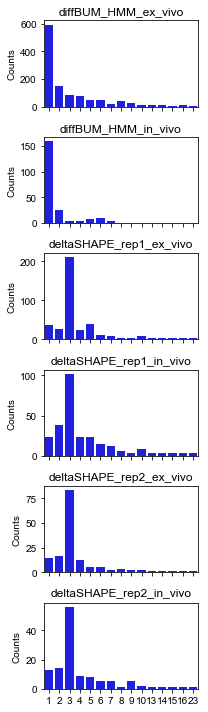

In [51]:
numberofplots = len(intervallengthcounter.keys())
samples = list(intervallengthcounter.keys())
fig,ax = plt.subplots(numberofplots,figsize=[3,10],sharex=True)
for i in range(numberofplots):
    sample = samples[i]
    data = intervallengthcounter[sample]
    x = list(data.keys())
    y = list(data.values())
    sns.barplot(x,y,ax=ax[i],color="blue")
    ax[i].set_title(sample)
    ax[i].set_ylabel('Counts')
plt.tight_layout()
fig.savefig("Distribution_of_stretches_of_diff_mod_nucleotides_v2.pdf",dpi=400)

### Now running everything through fimo to get the coordinates for the motifs identified by deltaSHAPE and diffBUM-HMM. 
This would be a useful resource for people studying Xist and Xist RBPs.

In [3]:
directories = glob.glob("MEME_V2*")

In [5]:
directories

['MEME_V2deltaSHAPE_rep_1_in_vivo_30_mers',
 'MEME_V2deltaSHAPE_rep_1_ex_vivo_30_mers',
 'MEME_V2diffBUM_HMM_ex_vivo_30_mers',
 'MEME_V2diffBUM_HMM_in_vivo_30_mers',
 'MEME_V2deltaSHAPE_rep_2_ex_vivo_30_mers',
 'MEME_V2deltaSHAPE_rep_2_in_vivo_30_mers']

In [7]:
directories = " ".join(directories)

In [11]:
%%bash -s "$directories"

DIR=$HOME/meme/bin

for i in $1
do
    $DIR/fimo \
    --oc $i \
    --verbosity 1 \
    $i/meme_out/meme.txt \
    ../../Reference_sequences/Xist.fa &
done